## MOBILITY

Analyze taxi mobility in Rome, Italy.  

The dataset contains mobility traces of taxi cabs in Rome, Italy. It contains GPS coordinates of approximately 320 taxis collected over 30 days.


Data source:
Taxi: https://ieee-dataport.org/open-access/crawdad-romataxi  
Tesselation: https://www.info.roma.it/mappa_confini_storici_roma.asp

In [93]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import skmob
from skmob.preprocessing import filtering
from skmob.preprocessing import compression
import geopandas as gpd
from skmob.utils import plot
import matplotlib.pyplot as plt
import folium
from folium import plugins
import pandas as pd
import numpy as np
import tarfile
from skmob.preprocessing import detection
import pickle

# Error functions
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error

# Forecasting
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


In [94]:
# Configuration settings for Matplotlib
plt.rcParams["figure.figsize"] = (9, 6) # (w, h)
plt.rcParams["legend.fontsize"] = 20
plt.rcParams['grid.alpha'] = 0.15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 2.5

In [78]:
# Read tessellation data
file = ".\data\zone_rioni_quartieri.geojson"
tessellation = gpd.read_file(file)
tessellation = tessellation.explode() # explode to unhook polygon from multipolygon
tessellation['tile_ID'] = range(len(tessellation)) # adding a tile_ID as unique identifier for scikit mob
tessellation.head()

Name  \
0 0   Q.VII Prenestino Labicano   
1 0               Q.I Flaminio    
2 0  Q.XXII Collatino-Labicano    
3 0           Q.VIII Tuscolano    
4 0             Q.VI Tiburtino    

                                              geometry  tile_ID  
0 0  POLYGON ((12.55904 41.89480, 12.55903 41.89482...        0  
1 0  POLYGON ((12.47598 41.91156, 12.47581 41.91214...        1  
2 0  POLYGON ((12.57500 41.89610, 12.57509 41.89693...        2  
3 0  POLYGON ((12.55313 41.87675, 12.55298 41.87680...        3  
4 0  POLYGON ((12.53204 41.90822, 12.53135 41.90822...        4

In [81]:
# Plot the tessellation
tess_style = {'color':'red', 'fillColor':'black', 'weight': 2}
popup_features=['tile_ID', 'Name']
map_f = plot.plot_gdf(tessellation, zoom=10, style_func_args=tess_style, 
             popup_features=popup_features)
map_f

## Read the taxi dataset

In [324]:
# Extract the file from the tar.gz archive
tar_path = './data/taxi_february.tar.gz'
extract_dir = './extracted_data'

# Extracting the tar.gz file
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path=extract_dir)

extracted_file_path = f'{extract_dir}/taxi_february.txt'

# Step 2: Define the custom date parser
mydateparser = lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f%z')

# Step 3: Read the extracted file as a CSV
tdf = skmob.TrajDataFrame(
    pd.read_csv(extracted_file_path, 
                sep=';', 
                names=['driver_id', 'timestamp', 'position'], 
                parse_dates=['timestamp'], 
                date_parser=mydateparser)
    .assign(
        lon=lambda df: df['position'].str.extract(r'POINT\([\d\.]+ ([\d\.]+)\)')[0].astype(float),
        lat=lambda df: df['position'].str.extract(r'POINT\(([\d\.]+) [\d\.]+\)')[0].astype(float)
    ).drop(columns=['position']),
    longitude='lon', 
    latitude='lat',
    datetime='timestamp', 
    user_id='driver_id'
).sort_values(by=['uid', 'datetime'])

# Step 4: Print results
print('records: %s' % len(tdf))
print('taxis: %s' % len(tdf['uid'].unique()))
print('period: %s - %s' % (tdf.datetime.min(), tdf.datetime.max()))


records: 21817851
taxis: 316
period: 2014-02-01 00:00:00.739166+01:00 - 2014-03-02 23:59:58.943143+01:00


In [325]:
# Save the TrajDataFrame object with pickle
with open('tdf.pkl', 'wb') as f:
    pickle.dump(tdf, f)

In [18]:
# Load the TrajDataFrame object
with open('tdf.pkl', 'rb') as f:
    tdf = pickle.load(f)

# Print records, taxi and period
print('records: %s' % len(tdf))
print('taxis: %s' % len(tdf['uid'].unique()))
print('period: %s - %s' % (tdf.datetime.min(), tdf.datetime.max()))

records: 21817851
taxis: 316
period: 2014-02-01 00:00:00.739166+01:00 - 2014-03-02 23:59:58.943143+01:00


In [19]:
tdf

uid                         datetime        lng        lat
33          2 2014-02-01 00:00:10.168741+01:00  12.504367  41.908130
89          2 2014-02-01 00:00:25.774039+01:00  12.506601  41.908663
138         2 2014-02-01 00:00:40.261960+01:00  12.507911  41.909040
191         2 2014-02-01 00:00:56.451894+01:00  12.507911  41.909040
240         2 2014-02-01 00:01:09.895936+01:00  12.507911  41.909040
...       ...                              ...        ...        ...
21555951  374 2014-03-02 14:56:17.811968+01:00  12.546910  41.876802
21556007  374 2014-03-02 14:56:25.973913+01:00  12.546907  41.876801
21556046  374 2014-03-02 14:56:32.288904+01:00  12.546901  41.876818
21556086  374 2014-03-02 14:56:38.831666+01:00  12.546911  41.876818
21556132  374 2014-03-02 14:56:45.891198+01:00  12.546859  41.876811

[21817851 rows x 4 columns]

In [328]:
#Plot all the trajectories
tdf.plot_trajectory(hex_color='red')

In [329]:
print(tdf.shape)
tdf.head()

(21817851, 4)


uid                         datetime        lng        lat
33     2 2014-02-01 00:00:10.168741+01:00  12.504367  41.908130
89     2 2014-02-01 00:00:25.774039+01:00  12.506601  41.908663
138    2 2014-02-01 00:00:40.261960+01:00  12.507911  41.909040
191    2 2014-02-01 00:00:56.451894+01:00  12.507911  41.909040
240    2 2014-02-01 00:01:09.895936+01:00  12.507911  41.909040

In [330]:
# Top 50 unique taxi names

tdf = tdf[tdf['uid'].isin(tdf['uid'].unique()[:50])]
print(tdf.shape)
tdf.head()

(3703843, 4)


uid                         datetime        lng        lat
33     2 2014-02-01 00:00:10.168741+01:00  12.504367  41.908130
89     2 2014-02-01 00:00:25.774039+01:00  12.506601  41.908663
138    2 2014-02-01 00:00:40.261960+01:00  12.507911  41.909040
191    2 2014-02-01 00:00:56.451894+01:00  12.507911  41.909040
240    2 2014-02-01 00:01:09.895936+01:00  12.507911  41.909040

## Preprocessing  

### FIltering

The speed value is not a fixed value that is always good, it depends on the context we are analyzing.  
Since we are working with taxis, a speed that could be the plausible is 250 km/h  

In [20]:
# 
%%time
f_tdf = filtering.filter(tdf, max_speed_kmh=250.0)
print('Number of records:\t%s'%len(f_tdf))
print('Filtered points:\t%s'%(len(tdf) - len(f_tdf)))

Number of records:	21518255
Filtered points:	299596
CPU times: total: 10min 7s
Wall time: 11min 20s


### Compression and simplification of the trajectory

All points that are close together within the selected radius are all included in a single point to reduce the number of points in GPS trajectories

In [37]:
%%time
fc_tdf = compression.compress(f_tdf, spatial_radius_km=0.03)
print('Points of the filtered trajectory:\t%s'%len(f_tdf))
print('Points of the compressed trajectory:\t%s'%len(fc_tdf))
print('Compressed points:\t\t\t%s'%(len(f_tdf)-len(fc_tdf)))

Points of the filtered trajectory:	21518255
Points of the compressed trajectory:	7716272
Compressed points:			13801983
CPU times: total: 19min 5s
Wall time: 21min 50s


### Detect stops on the trajectories  

Detect the stay locations (or stops) for each taxi. A stop is detected when the taxi spends at least `minutes_for_a_stop` minutes within a distance `stop_radius_factor * spatial_radius` km.  

It is reasonable to consider a stop in the radius of 30 m and the taxi stopped for at least 15 minutes using `minutes_for_a_stop=15.0` and `spatial_radius_km=0.03`

In [38]:
fcs_tdf = detection.stay_locations(fc_tdf, minutes_for_a_stop=15, spatial_radius_km=0.03)

fcs_tdf.head()

uid                         datetime        lng        lat  \
0   2 2014-02-01 06:08:00.070977+01:00  12.376344  41.888019   
1   2 2014-02-01 22:23:17.290280+01:00  12.469132  41.905629   
2   2 2014-02-02 00:00:10.410108+01:00  12.488194  41.903711   
3   2 2014-02-02 03:08:21.497636+01:00  12.508989  41.886258   
4   2 2014-02-02 06:28:34.338133+01:00  12.376675  41.888171   

                   leaving_datetime  
0  2014-02-01 21:05:10.951712+01:00  
1  2014-02-01 23:00:14.127245+01:00  
2  2014-02-02 00:24:45.348371+01:00  
3  2014-02-02 03:36:15.520936+01:00  
4  2014-02-02 19:55:33.619671+01:00

### Mapping the stops to the tessellation

With `.mapping` it is possible to associate each pair of latitude and longitude of the TrajDataFrame to the corresponding tile of tessellation

In [39]:
map_fcs_tdf = fcs_tdf.mapping(tessellation, remove_na=True) #remove_nan to remove the points that are not associated with any tile
map_fcs_tdf.head()

uid                         datetime        lng        lat  \
0   2 2014-02-01 06:08:00.070977+01:00  12.376344  41.888019   
1   2 2014-02-01 22:23:17.290280+01:00  12.469132  41.905629   
2   2 2014-02-02 00:00:10.410108+01:00  12.488194  41.903711   
3   2 2014-02-02 03:08:21.497636+01:00  12.508989  41.886258   
4   2 2014-02-02 06:28:34.338133+01:00  12.376675  41.888171   

                   leaving_datetime  tile_ID  
0  2014-02-01 21:05:10.951712+01:00       98  
1  2014-02-01 23:00:14.127245+01:00       50  
2  2014-02-02 00:24:45.348371+01:00       41  
3  2014-02-02 03:36:15.520936+01:00       62  
4  2014-02-02 19:55:33.619671+01:00       98

In [40]:
tess_style = {'color':'red', 'fillColor':'black', 'weight': 2}
popup_features=['tile_ID', 'po_name', 'area']
map_f = plot.plot_gdf(tessellation, zoom=9, style_func_args=tess_style, 
             popup_features=popup_features)
map_f = map_fcs_tdf.plot_stops(map_f=map_f)
map_f

### Plot a cloropleth map of the number of GPS points in each tile

In [45]:
def plot_cloropleth(tdf, tessellation, map_f=None):
    if map_f is None:
        m = folium.Map(location=[tdf['lat'].mean(), tdf['lng'].mean()], zoom_start=11, control_scale=True)
    else:
        m = map_f
    
    points_per_tile = tdf.groupby('tile_ID').count().reset_index()[['tile_ID', 'uid']].rename(columns={'uid': 'n_points'})

    m.choropleth(
        geo_data = tessellation.reset_index().set_index('tile_ID').to_json(),
        data = points_per_tile,
        columns=['tile_ID', 'n_points'],
        key_on='feature.id',
        fill_color='YlGn',
        legend_name='Number of points',
        highlight=True
    )
    return m

In [46]:
map_f = plot_cloropleth(map_fcs_tdf, tessellation)
map_f

As first visualization we can notice how the center areas and the airport are those with the highest number of stops. Now it is possible to filter all the stop locations that occur in a specific tile tile, of our interest, and then show a sample.

In [47]:
center_tdf = map_fcs_tdf[map_fcs_tdf['tile_ID'] == '6']
center_tdf.head()

uid                         datetime        lng        lat  \
104   3 2014-02-03 18:28:02.437655+01:00  12.491562  41.918040   
109   3 2014-02-04 20:31:51.012212+01:00  12.491723  41.917951   
134   3 2014-02-10 07:57:56.431480+01:00  12.491632  41.918009   
144   3 2014-02-11 12:10:21.113598+01:00  12.491699  41.918074   
150   3 2014-02-12 11:34:02.383354+01:00  12.494923  41.919471   

                     leaving_datetime tile_ID  
104  2014-02-03 19:56:16.377288+01:00       6  
109  2014-02-04 20:52:29.039669+01:00       6  
134  2014-02-10 08:50:56.786252+01:00       6  
144  2014-02-11 13:05:00.954736+01:00       6  
150  2014-02-12 12:11:22.787337+01:00       6

### Computing a time series for the number of stops in the center of the city (Q.III Pinciano)

To make a Time Series we know that each of these stops has a time value of that stop and we set it as an index

In [50]:
ts_center = center_tdf.set_index('datetime')
ts_center.head()

uid        lng        lat  \
datetime                                                     
2014-02-03 18:28:02.437655+01:00   3  12.491562  41.918040   
2014-02-04 20:31:51.012212+01:00   3  12.491723  41.917951   
2014-02-10 07:57:56.431480+01:00   3  12.491632  41.918009   
2014-02-11 12:10:21.113598+01:00   3  12.491699  41.918074   
2014-02-12 11:34:02.383354+01:00   3  12.494923  41.919471   

                                                  leaving_datetime tile_ID  
datetime                                                                    
2014-02-03 18:28:02.437655+01:00  2014-02-03 19:56:16.377288+01:00       6  
2014-02-04 20:31:51.012212+01:00  2014-02-04 20:52:29.039669+01:00       6  
2014-02-10 07:57:56.431480+01:00  2014-02-10 08:50:56.786252+01:00       6  
2014-02-11 12:10:21.113598+01:00  2014-02-11 13:05:00.954736+01:00       6  
2014-02-12 11:34:02.383354+01:00  2014-02-12 12:11:22.787337+01:00       6

Now it is possible to make a sample with a more constant sampling rate identified by day.

In [51]:
ts_center = ts_center.resample('D').agg("count")
ts_center.head()

uid  lng  lat  leaving_datetime  tile_ID
datetime                                                           
2014-02-01 00:00:00+01:00   49   49   49                49       49
2014-02-02 00:00:00+01:00   36   36   36                36       36
2014-02-03 00:00:00+01:00   92   92   92                92       92
2014-02-04 00:00:00+01:00   76   76   76                76       76
2014-02-05 00:00:00+01:00   63   63   63                63       63

In [52]:
ts_center = pd.Series(ts_center['uid']) #From trajdataframe to series
ts_center.head()

datetime
2014-02-01 00:00:00+01:00    49
2014-02-02 00:00:00+01:00    36
2014-02-03 00:00:00+01:00    92
2014-02-04 00:00:00+01:00    76
2014-02-05 00:00:00+01:00    63
Freq: D, Name: uid, dtype: int64

Plotting the series we see that there is an increase in runs on certain days and this thing is repeated, so it could be a weekly trend.

<Axes: xlabel='datetime'>

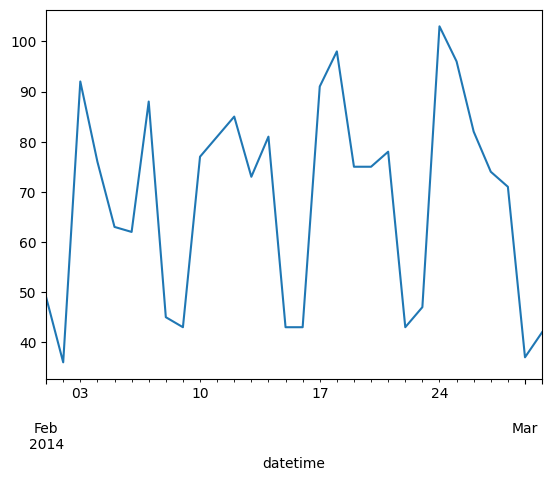

In [53]:
ts_center.plot(legend=False)

The `get_time_series` function is designed to generate a time series by counting the occurrences of an event based on certain parameters, such as tile_ID, po_name, and time_unit:

In [55]:
def get_time_series(ext_mapped_tdf, tile_ID=None, po_name='ALL', time_unit='D'):
  if tile_ID is None:
    if po_name == 'ALL':
      selected_tdf = ext_mapped_tdf
    else:
      selected_tdf = ext_mapped_tdf[ext_mapped_tdf['po_name'] == po_name]
  else:  
    selected_tdf = ext_mapped_tdf[ext_mapped_tdf['tile_ID'] == tile_ID]
  ts_tile = selected_tdf.set_index('datetime').resample(time_unit).agg("count")
  ts_tile = pd.Series(ts_tile['uid'])
  return ts_tile

In [63]:
tessellation = tessellation['tile_ID'].astype(str)
ext_map_fcs_tdf = map_fcs_tdf.merge(tessellation, on='tile_ID')
ext_map_fcs_tdf.head()

uid                         datetime        lng        lat  \
0   2 2014-02-01 06:08:00.070977+01:00  12.376344  41.888019   
1   2 2014-02-02 06:28:34.338133+01:00  12.376675  41.888171   
2   2 2014-02-03 00:36:56.674305+01:00  12.376393  41.887924   
3   2 2014-02-04 01:43:46.601249+01:00  12.378163  41.886785   
4   2 2014-02-05 03:21:49.695040+01:00  12.376560  41.887936   

                   leaving_datetime tile_ID  
0  2014-02-01 21:05:10.951712+01:00      98  
1  2014-02-02 19:55:33.619671+01:00      98  
2  2014-02-03 21:23:41.850824+01:00      98  
3  2014-02-04 22:09:31.315207+01:00      98  
4  2014-02-05 20:45:48.731505+01:00      98

<Axes: xlabel='datetime'>

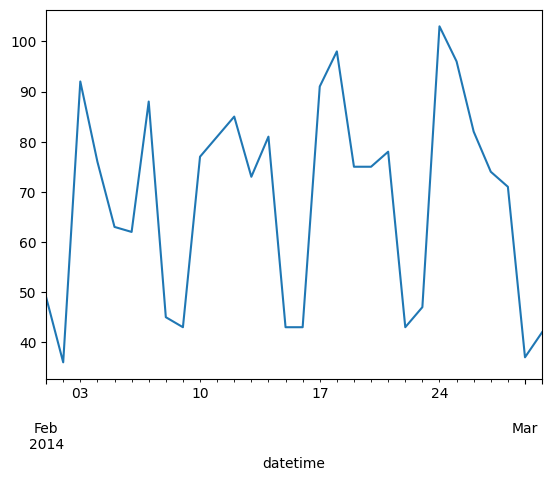

In [90]:
get_time_series(ext_map_fcs_tdf, tile_ID='6').plot() # Q.III Pinciano

<Axes: xlabel='datetime'>

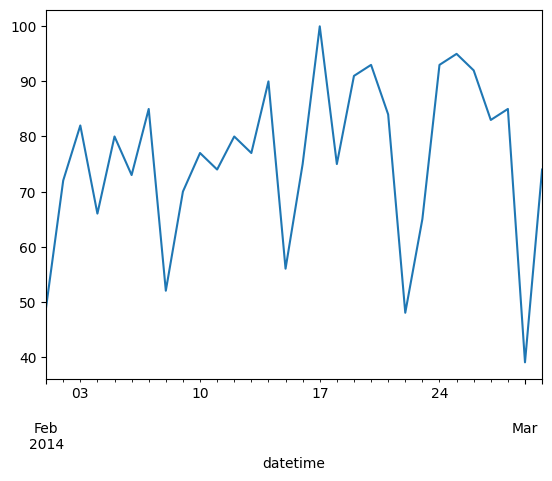

In [77]:
get_time_series(ext_map_fcs_tdf, tile_ID='116').plot() # Airport

<Axes: xlabel='datetime'>

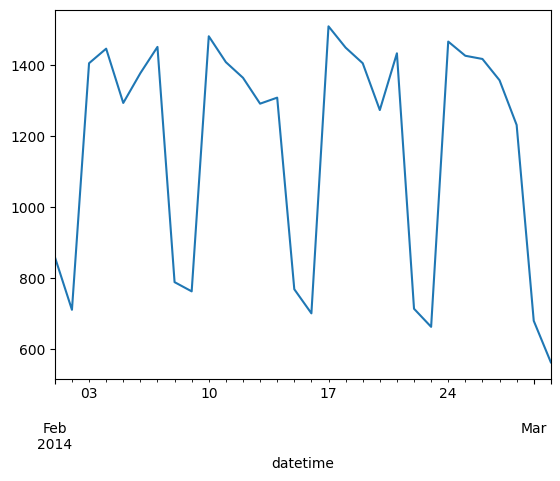

In [99]:
get_time_series(ext_map_fcs_tdf, po_name='ALL', time_unit='D').plot() # All zones, daily

<Axes: xlabel='datetime'>

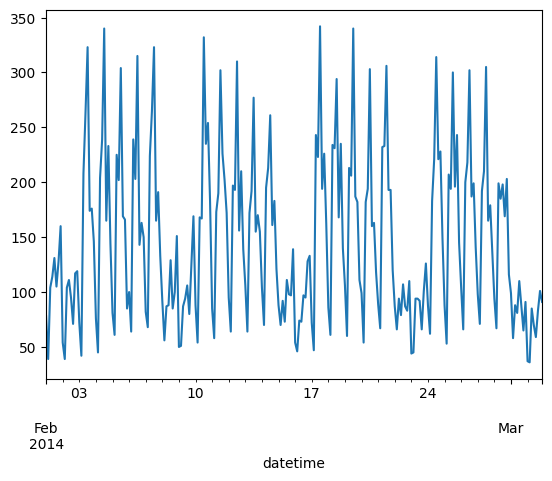

In [100]:
get_time_series(ext_map_fcs_tdf, po_name='ALL', time_unit='3h').plot() # All zones, each 3h

<Axes: xlabel='datetime'>

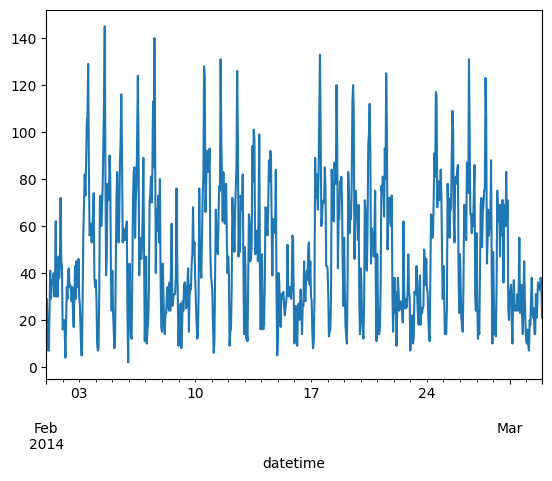

In [101]:
get_time_series(ext_map_fcs_tdf, po_name='ALL', time_unit='1h').plot() # All zones, each 1h

## TIMESERIES

### Create Daily, Hourly, and 3-hourly time series

Create time series with daily, one-hour and three-hour granularity

In [122]:
ext_map_fcs_tdf['tile_ID'] = ext_map_fcs_tdf['tile_ID'].astype(int)

In [124]:
series_list_D, series_list_1h, series_list_3h = [], [], []

for tile_ID in tessellation['tile_ID'].unique():
  # get daily time series
  ts_D = get_time_series(ext_map_fcs_tdf, tile_ID=tile_ID, time_unit='D')
  if len(ts_D) > 0:
    ts_D_df = pd.DataFrame(ts_D)
    ts_D_df.columns = ['tile_' + str(tile_ID)]
    series_list_D.append(ts_D_df)
    
  # get 1h time series
  ts_1h = get_time_series(ext_map_fcs_tdf, tile_ID=tile_ID, time_unit='h')
  if len(ts_1h) > 0:
    ts_1h_df = pd.DataFrame(ts_1h)
    ts_1h_df.columns = ['tile_' + str(tile_ID)]
    series_list_1h.append(ts_1h_df)
    
  # get 3h time series
  ts_3h = get_time_series(ext_map_fcs_tdf, tile_ID=tile_ID, time_unit='3h')
  if len(ts_3h) > 0:
    ts_3h_df = pd.DataFrame(ts_3h)
    ts_3h_df.columns = ['tile_' + str(tile_ID)]
    series_list_3h.append(ts_3h_df)

This way here we calculate them for each neighborhood separately, but then we concatenate them

In [126]:
df_D = pd.concat(series_list_D, axis=1)
df_D.head()

tile_0  tile_1  tile_2  tile_3  tile_4  tile_5  \
datetime                                                                    
2014-02-01 00:00:00+01:00     8.0     4.0       1      11       2       5   
2014-02-02 00:00:00+01:00     3.0     1.0       4       5       5       4   
2014-02-03 00:00:00+01:00     5.0     3.0       4      15       7      12   
2014-02-04 00:00:00+01:00     6.0     8.0       5      16       8      18   
2014-02-05 00:00:00+01:00     7.0     2.0      14      23      14      12   

                           tile_6  tile_7  tile_8  tile_9  ...  tile_107  \
datetime                                                   ...             
2014-02-01 00:00:00+01:00      49      21      34      12  ...       4.0   
2014-02-02 00:00:00+01:00      36      17      18       8  ...       1.0   
2014-02-03 00:00:00+01:00      92      50      45      19  ...       4.0   
2014-02-04 00:00:00+01:00      76      49      53      20  ...       1.0   
2014-02-05 00:00:00+01:00      63      45      54      15  ...       5.0   

                           tile_108  tile_109  tile_110  tile_111  tile_112  \
datetime                                                                      
2014-02-01 00:00:00+01:00         4       6.0       4.0         1       NaN   
2014-02-02 00:00:00+01:00         1       5.0       5.0         0       NaN   
2014-02-03 00:00:00+01:00        10      11.0       0.0         2       NaN   
2014-02-04 00:00:00+01:00        13      14.0       2.0         5       1.0   
2014-02-05 00:00:00+01:00        22      15.0       0.0         2       0.0   

                           tile_113  tile_114  tile_115  tile_116  
datetime                                                           
2014-02-01 00:00:00+01:00       2.0       NaN       NaN        49  
2014-02-02 00:00:00+01:00       1.0       NaN       NaN        72  
2014-02-03 00:00:00+01:00       0.0       NaN       1.0        82  
2014-02-04 00:00:00+01:00       0.0       NaN       3.0        66  
2014-02-05 00:00:00+01:00       0.0       1.0       0.0        80  

[5 rows x 113 columns]

In [127]:
df_D = df_D.fillna(0) #Filling na with zeros
df_D.head()

tile_0  tile_1  tile_2  tile_3  tile_4  tile_5  \
datetime                                                                    
2014-02-01 00:00:00+01:00     8.0     4.0       1      11       2       5   
2014-02-02 00:00:00+01:00     3.0     1.0       4       5       5       4   
2014-02-03 00:00:00+01:00     5.0     3.0       4      15       7      12   
2014-02-04 00:00:00+01:00     6.0     8.0       5      16       8      18   
2014-02-05 00:00:00+01:00     7.0     2.0      14      23      14      12   

                           tile_6  tile_7  tile_8  tile_9  ...  tile_107  \
datetime                                                   ...             
2014-02-01 00:00:00+01:00      49      21      34      12  ...       4.0   
2014-02-02 00:00:00+01:00      36      17      18       8  ...       1.0   
2014-02-03 00:00:00+01:00      92      50      45      19  ...       4.0   
2014-02-04 00:00:00+01:00      76      49      53      20  ...       1.0   
2014-02-05 00:00:00+01:00      63      45      54      15  ...       5.0   

                           tile_108  tile_109  tile_110  tile_111  tile_112  \
datetime                                                                      
2014-02-01 00:00:00+01:00         4       6.0       4.0         1       0.0   
2014-02-02 00:00:00+01:00         1       5.0       5.0         0       0.0   
2014-02-03 00:00:00+01:00        10      11.0       0.0         2       0.0   
2014-02-04 00:00:00+01:00        13      14.0       2.0         5       1.0   
2014-02-05 00:00:00+01:00        22      15.0       0.0         2       0.0   

                           tile_113  tile_114  tile_115  tile_116  
datetime                                                           
2014-02-01 00:00:00+01:00       2.0       0.0       0.0        49  
2014-02-02 00:00:00+01:00       1.0       0.0       0.0        72  
2014-02-03 00:00:00+01:00       0.0       0.0       1.0        82  
2014-02-04 00:00:00+01:00       0.0       0.0       3.0        66  
2014-02-05 00:00:00+01:00       0.0       1.0       0.0        80  

[5 rows x 113 columns]

Let's save these time series in CSV files 

In [128]:
df_D.to_csv('./data/ts_cabs/sf_series_D.csv', sep=',')
df_D.head()

tile_0  tile_1  tile_2  tile_3  tile_4  tile_5  \
datetime                                                                    
2014-02-01 00:00:00+01:00     8.0     4.0       1      11       2       5   
2014-02-02 00:00:00+01:00     3.0     1.0       4       5       5       4   
2014-02-03 00:00:00+01:00     5.0     3.0       4      15       7      12   
2014-02-04 00:00:00+01:00     6.0     8.0       5      16       8      18   
2014-02-05 00:00:00+01:00     7.0     2.0      14      23      14      12   

                           tile_6  tile_7  tile_8  tile_9  ...  tile_107  \
datetime                                                   ...             
2014-02-01 00:00:00+01:00      49      21      34      12  ...       4.0   
2014-02-02 00:00:00+01:00      36      17      18       8  ...       1.0   
2014-02-03 00:00:00+01:00      92      50      45      19  ...       4.0   
2014-02-04 00:00:00+01:00      76      49      53      20  ...       1.0   
2014-02-05 00:00:00+01:00      63      45      54      15  ...       5.0   

                           tile_108  tile_109  tile_110  tile_111  tile_112  \
datetime                                                                      
2014-02-01 00:00:00+01:00         4       6.0       4.0         1       0.0   
2014-02-02 00:00:00+01:00         1       5.0       5.0         0       0.0   
2014-02-03 00:00:00+01:00        10      11.0       0.0         2       0.0   
2014-02-04 00:00:00+01:00        13      14.0       2.0         5       1.0   
2014-02-05 00:00:00+01:00        22      15.0       0.0         2       0.0   

                           tile_113  tile_114  tile_115  tile_116  
datetime                                                           
2014-02-01 00:00:00+01:00       2.0       0.0       0.0        49  
2014-02-02 00:00:00+01:00       1.0       0.0       0.0        72  
2014-02-03 00:00:00+01:00       0.0       0.0       1.0        82  
2014-02-04 00:00:00+01:00       0.0       0.0       3.0        66  
2014-02-05 00:00:00+01:00       0.0       1.0       0.0        80  

[5 rows x 113 columns]

In [144]:
url = './data/ts_cabs/sf_series_D.csv'
df_all_ts = pd.read_csv(url, parse_dates=True, index_col='datetime')
df_all_ts.head()

tile_0  tile_1  tile_2  tile_3  tile_4  tile_5  \
datetime                                                                    
2014-02-01 00:00:00+01:00     8.0     4.0       1      11       2       5   
2014-02-02 00:00:00+01:00     3.0     1.0       4       5       5       4   
2014-02-03 00:00:00+01:00     5.0     3.0       4      15       7      12   
2014-02-04 00:00:00+01:00     6.0     8.0       5      16       8      18   
2014-02-05 00:00:00+01:00     7.0     2.0      14      23      14      12   

                           tile_6  tile_7  tile_8  tile_9  ...  tile_107  \
datetime                                                   ...             
2014-02-01 00:00:00+01:00      49      21      34      12  ...       4.0   
2014-02-02 00:00:00+01:00      36      17      18       8  ...       1.0   
2014-02-03 00:00:00+01:00      92      50      45      19  ...       4.0   
2014-02-04 00:00:00+01:00      76      49      53      20  ...       1.0   
2014-02-05 00:00:00+01:00      63      45      54      15  ...       5.0   

                           tile_108  tile_109  tile_110  tile_111  tile_112  \
datetime                                                                      
2014-02-01 00:00:00+01:00         4       6.0       4.0         1       0.0   
2014-02-02 00:00:00+01:00         1       5.0       5.0         0       0.0   
2014-02-03 00:00:00+01:00        10      11.0       0.0         2       0.0   
2014-02-04 00:00:00+01:00        13      14.0       2.0         5       1.0   
2014-02-05 00:00:00+01:00        22      15.0       0.0         2       0.0   

                           tile_113  tile_114  tile_115  tile_116  
datetime                                                           
2014-02-01 00:00:00+01:00       2.0       0.0       0.0        49  
2014-02-02 00:00:00+01:00       1.0       0.0       0.0        72  
2014-02-03 00:00:00+01:00       0.0       0.0       1.0        82  
2014-02-04 00:00:00+01:00       0.0       0.0       3.0        66  
2014-02-05 00:00:00+01:00       0.0       1.0       0.0        80  

[5 rows x 113 columns]

In [130]:
df_1h = pd.concat(series_list_1h, axis=1).fillna(0)
df_1h.to_csv('./data/ts_cabs/sf_series_1h.csv', sep=',')
df_1h.head()

tile_0  tile_1  tile_2  tile_3  tile_4  tile_5  \
datetime                                                                    
2014-02-01 00:00:00+01:00     0.0     0.0     0.0     0.0     0.0     0.0   
2014-02-01 01:00:00+01:00     2.0     0.0     0.0     2.0     0.0     0.0   
2014-02-01 02:00:00+01:00     0.0     0.0     0.0     0.0     0.0     0.0   
2014-02-01 03:00:00+01:00     0.0     1.0     0.0     0.0     0.0     0.0   
2014-02-01 04:00:00+01:00     0.0     0.0     0.0     0.0     0.0     0.0   

                           tile_6  tile_7  tile_8  tile_9  ...  tile_107  \
datetime                                                   ...             
2014-02-01 00:00:00+01:00     1.0       1     0.0     0.0  ...       0.0   
2014-02-01 01:00:00+01:00     1.0       1     1.0     1.0  ...       0.0   
2014-02-01 02:00:00+01:00     0.0       0     0.0     0.0  ...       1.0   
2014-02-01 03:00:00+01:00     0.0       0     0.0     0.0  ...       1.0   
2014-02-01 04:00:00+01:00     0.0       0     0.0     0.0  ...       0.0   

                           tile_108  tile_109  tile_110  tile_111  tile_112  \
datetime                                                                      
2014-02-01 00:00:00+01:00       0.0       0.0       0.0       0.0       0.0   
2014-02-01 01:00:00+01:00       0.0       0.0       1.0       0.0       0.0   
2014-02-01 02:00:00+01:00       0.0       0.0       0.0       0.0       0.0   
2014-02-01 03:00:00+01:00       0.0       1.0       0.0       0.0       0.0   
2014-02-01 04:00:00+01:00       0.0       0.0       0.0       0.0       0.0   

                           tile_113  tile_114  tile_115  tile_116  
datetime                                                           
2014-02-01 00:00:00+01:00       0.0       0.0       0.0         1  
2014-02-01 01:00:00+01:00       0.0       0.0       0.0         0  
2014-02-01 02:00:00+01:00       1.0       0.0       0.0         0  
2014-02-01 03:00:00+01:00       0.0       0.0       0.0         0  
2014-02-01 04:00:00+01:00       0.0       0.0       0.0         0  

[5 rows x 113 columns]

In [131]:
df_3h = pd.concat(series_list_3h, axis=1).fillna(0)
df_3h.to_csv('./data/ts_cabs/sf_series_3h.csv', sep=',')
df_3h.head()

tile_0  tile_1  tile_2  tile_3  tile_4  tile_5  \
datetime                                                                    
2014-02-01 00:00:00+01:00     2.0     0.0     0.0     2.0     0.0     0.0   
2014-02-01 03:00:00+01:00     0.0     1.0     0.0     0.0     0.0     0.0   
2014-02-01 06:00:00+01:00     0.0     1.0     0.0     2.0     0.0     0.0   
2014-02-01 09:00:00+01:00     0.0     0.0     0.0     1.0     0.0     0.0   
2014-02-01 12:00:00+01:00     3.0     1.0     0.0     4.0     1.0     1.0   

                           tile_6  tile_7  tile_8  tile_9  ...  tile_107  \
datetime                                                   ...             
2014-02-01 00:00:00+01:00       2       2       1     1.0  ...       1.0   
2014-02-01 03:00:00+01:00       0       3       3     1.0  ...       1.0   
2014-02-01 06:00:00+01:00       8       3       4     3.0  ...       1.0   
2014-02-01 09:00:00+01:00       8       5       1     0.0  ...       0.0   
2014-02-01 12:00:00+01:00      12       3       5     2.0  ...       1.0   

                           tile_108  tile_109  tile_110  tile_111  tile_112  \
datetime                                                                      
2014-02-01 00:00:00+01:00       0.0       0.0       1.0       0.0       0.0   
2014-02-01 03:00:00+01:00       0.0       2.0       0.0       0.0       0.0   
2014-02-01 06:00:00+01:00       0.0       1.0       0.0       0.0       0.0   
2014-02-01 09:00:00+01:00       0.0       2.0       1.0       0.0       0.0   
2014-02-01 12:00:00+01:00       2.0       1.0       0.0       0.0       0.0   

                           tile_113  tile_114  tile_115  tile_116  
datetime                                                           
2014-02-01 00:00:00+01:00       1.0       0.0       0.0         1  
2014-02-01 03:00:00+01:00       0.0       0.0       0.0         0  
2014-02-01 06:00:00+01:00       0.0       0.0       0.0         4  
2014-02-01 09:00:00+01:00       0.0       0.0       0.0        10  
2014-02-01 12:00:00+01:00       0.0       0.0       0.0        10  

[5 rows x 113 columns]

### Load the Airport (`116`) and Q.III Pinciano (`6`) time series

In [95]:
AIRPORT = 'tile_116'
CENTER = 'tile_6'

In [96]:
url = './data/ts_cabs/sf_series_3h.csv'
df_all = pd.read_csv(url, parse_dates=True, index_col='datetime')
df_all.head()

tile_0  tile_1  tile_2  tile_3  tile_4  tile_5  \
datetime                                                                    
2014-02-01 00:00:00+01:00     2.0     0.0     0.0     2.0     0.0     0.0   
2014-02-01 03:00:00+01:00     0.0     1.0     0.0     0.0     0.0     0.0   
2014-02-01 06:00:00+01:00     0.0     1.0     0.0     2.0     0.0     0.0   
2014-02-01 09:00:00+01:00     0.0     0.0     0.0     1.0     0.0     0.0   
2014-02-01 12:00:00+01:00     3.0     1.0     0.0     4.0     1.0     1.0   

                           tile_6  tile_7  tile_8  tile_9  ...  tile_107  \
datetime                                                   ...             
2014-02-01 00:00:00+01:00       2       2       1     1.0  ...       1.0   
2014-02-01 03:00:00+01:00       0       3       3     1.0  ...       1.0   
2014-02-01 06:00:00+01:00       8       3       4     3.0  ...       1.0   
2014-02-01 09:00:00+01:00       8       5       1     0.0  ...       0.0   
2014-02-01 12:00:00+01:00      12       3       5     2.0  ...       1.0   

                           tile_108  tile_109  tile_110  tile_111  tile_112  \
datetime                                                                      
2014-02-01 00:00:00+01:00       0.0       0.0       1.0       0.0       0.0   
2014-02-01 03:00:00+01:00       0.0       2.0       0.0       0.0       0.0   
2014-02-01 06:00:00+01:00       0.0       1.0       0.0       0.0       0.0   
2014-02-01 09:00:00+01:00       0.0       2.0       1.0       0.0       0.0   
2014-02-01 12:00:00+01:00       2.0       1.0       0.0       0.0       0.0   

                           tile_113  tile_114  tile_115  tile_116  
datetime                                                           
2014-02-01 00:00:00+01:00       1.0       0.0       0.0         1  
2014-02-01 03:00:00+01:00       0.0       0.0       0.0         0  
2014-02-01 06:00:00+01:00       0.0       0.0       0.0         4  
2014-02-01 09:00:00+01:00       0.0       0.0       0.0        10  
2014-02-01 12:00:00+01:00       0.0       0.0       0.0        10  

[5 rows x 113 columns]

Let's discard the last point because in this way we will be able to predict all the points of our Time Series in the prediction phase

In [97]:
ts1 = df_all[AIRPORT][:-1] # Airport
ts2 = df_all[CENTER][:-1] # Q.III Pinciano 

There is a certain correspondence, probably due to the fact that many taxi trips start or end at the airport and depart from the city center, which is the place of greatest tourist interest.

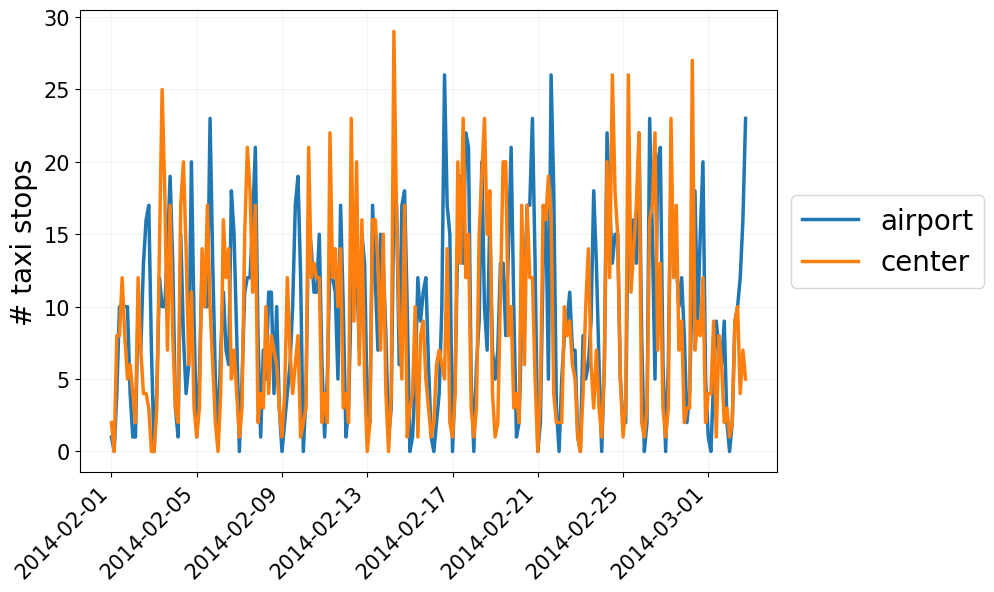

In [98]:
# Plotting the timeseries
plt.plot(ts1, label='airport')
plt.plot(ts2, label='center')
plt.ylabel('# taxi stops')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

It is possible to roughly predict how many taxis will be in attendance, for example to maximize profits. What is the best method?  

We are interested in making a forecast, a prediction of future values ​​based on an observation that we know up to this moment in time.

We will explore the main methods:  
- Holt
- SimpleExpSmoothing
- ExponentialSmoothing
- ARIMA
- SARIMAX

In [99]:
# Functions to evaluate the performance of a forecasting model
def r2_score(y_true, y_pred, ts):
    mu = np.mean(ts)
    total = np.sum((y_true - mu) ** 2)
    residuals = np.sum((y_true - y_pred) ** 2)
    return 1 - (residuals / total)


def absolute_percentage_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_pred)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(absolute_percentage_error(y_true, y_pred))


def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))


def total_absolute_percentage_error(y_true, y_pred):
    return np.sum(absolute_percentage_error(y_true, y_pred))


def evaluate(y_true, y_pred, ts):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAD': median_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred, ts),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'MAXAPE': max_absolute_percentage_error(y_true, y_pred),
        'TAPE': total_absolute_percentage_error(y_true, y_pred)
    }

In [100]:
ts1 = df_all[AIRPORT][:-1] # Airport

<Axes: xlabel='datetime'>

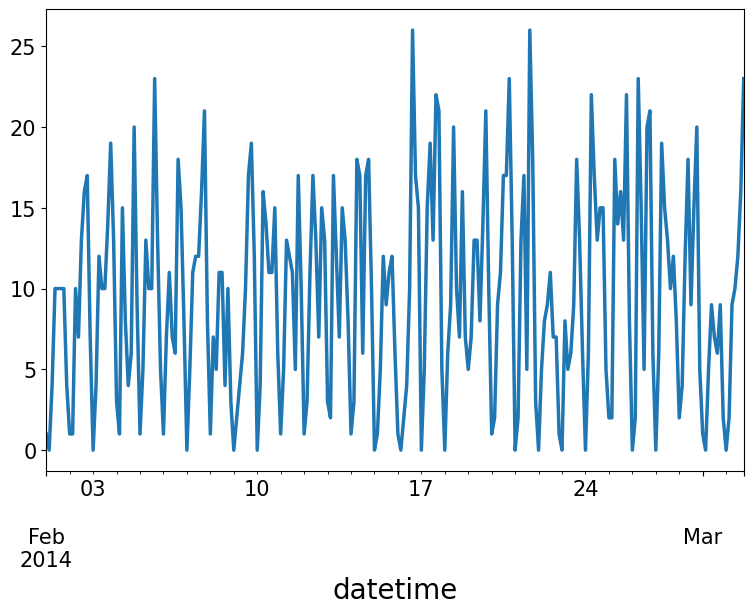

In [101]:
ts1.plot()

In [102]:
len(ts1)

239

### Train-test split

It is not possible to perform a train-test split by mixing the observations. We must maintain the chronological order of the events

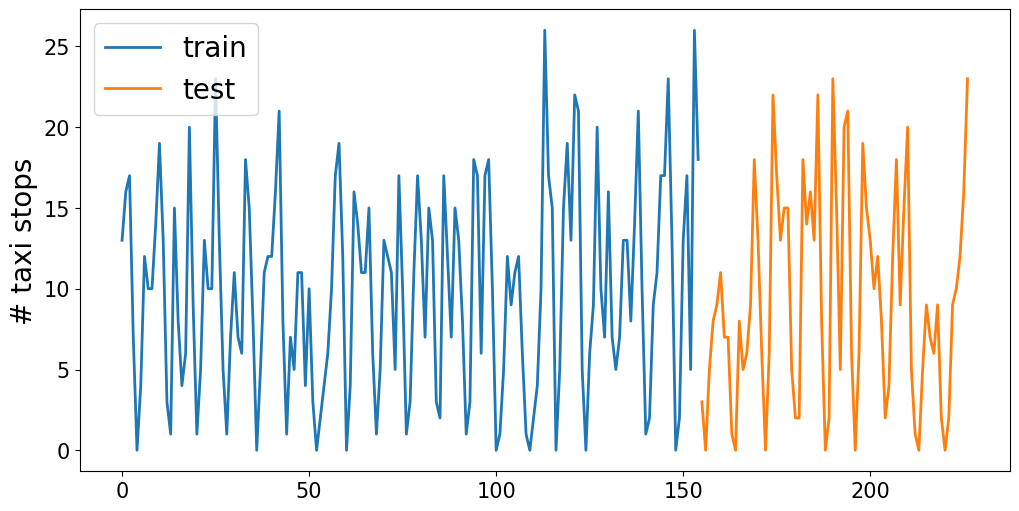

In [103]:
split_index = int(len(ts1)*0.7)
train, test = ts1.iloc[12:split_index], ts1.iloc[split_index:]
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(range(len(train)), train, label='train', linewidth=2)
plt.plot(range(len(train), len(train)+len(test)), test, linewidth=2, label='test')
plt.ylabel('# taxi stops')
plt.legend()
plt.show()

### Simple Exponential Smoothing

In [104]:
smoothing_level = 0.1
ses = SimpleExpSmoothing(train).fit(smoothing_level=smoothing_level, optimized=True)
pred = ses.predict(start=test.index[0], end=test.index[-1])

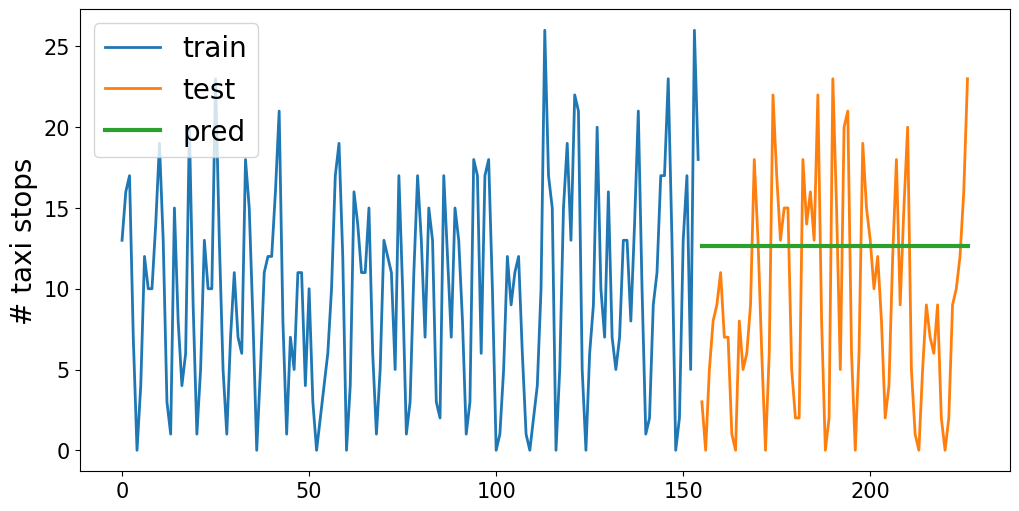

In [105]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(range(len(train)), train, label='train', linewidth=2)
plt.plot(range(len(train), len(train)+len(test)), test, label='test', linewidth=2)
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred', linewidth=3)
plt.ylabel('# taxi stops')
plt.legend()
plt.show()

As we can see the error is quite high. In any case it is not possible to capture what the trend is.

In [106]:
for k, v in evaluate(test, pred, ts1).items():
    print('%s %.3f' % (k, v))

MAE 6.342
RMSE 7.361
MAD 6.500
R2 -0.246
MAPE 0.501
MAXAPE 1.000
TAPE 36.094


### Holt

A more complex model of the simple exponential smoothing, which also takes into account seasonality and trend.

`smoothing_level=0.1`
`smoothing_slope=1`

In [128]:
smoothing_level=0.1
smoothing_slope=0.1

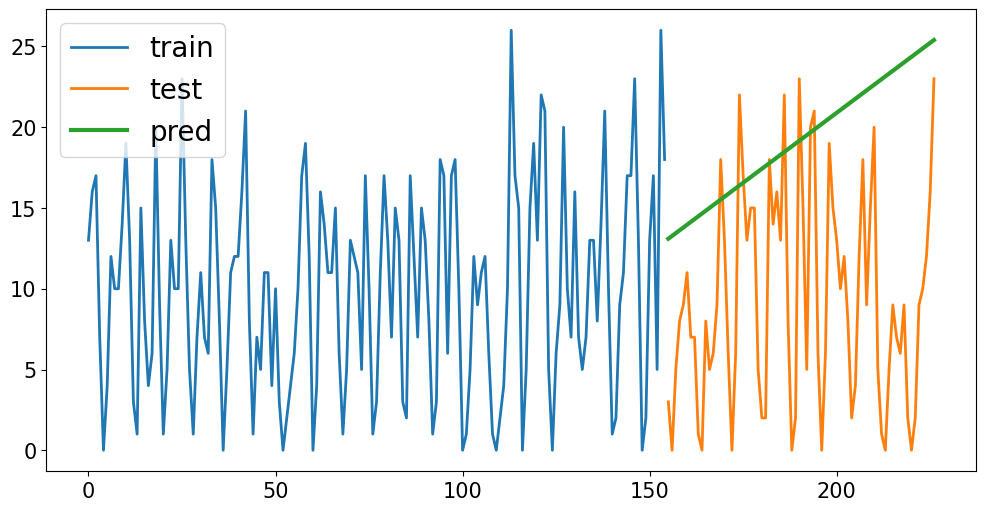

MAE 10.360
RMSE 12.235
MAD 9.967
R2 -2.443
MAPE 0.532
MAXAPE 1.000
TAPE 38.288


In [129]:
holt = Holt(train).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
pred = holt.predict(start=test.index[0], end=test.index[-1])
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(range(len(train)), train, label='train', linewidth=2)
plt.plot(range(len(train), len(train)+len(test)), test, label='test', linewidth=2)
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred', linewidth=3)
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts1).items():
    print('%s %.3f' % (k, v))

We have a value that does not follow the fluctuation trend very much but in any case the slope changes too much, even R2 has a strongly negative value

### Exponential Smoothing

`seasonal_periods=8` Every 8 times three hours I finished the day, so there will be a daily seasonality


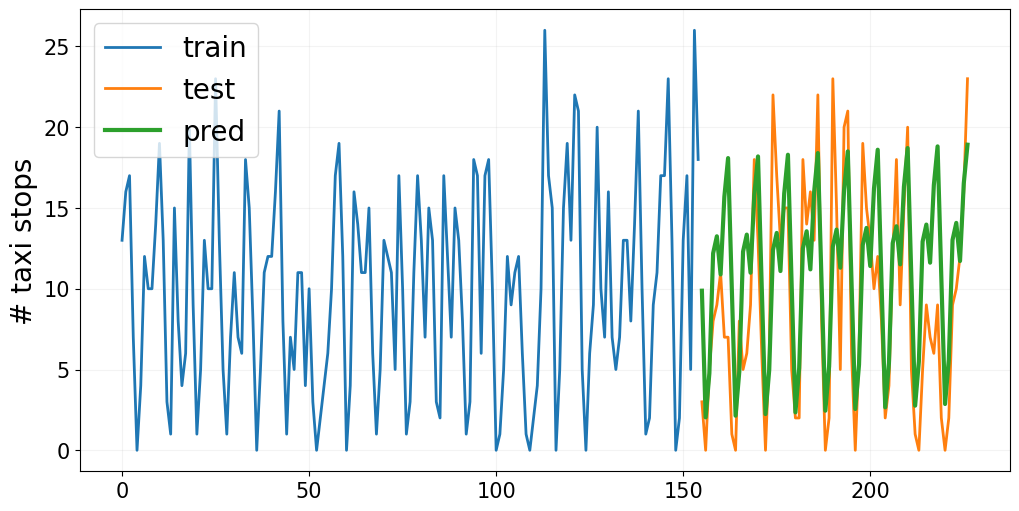

MAE 3.939
RMSE 4.836
MAD 3.421
R2 0.462
MAPE 0.412
MAXAPE 1.000
TAPE 29.680


In [109]:
seasonal_periods=8

es = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, trend='add', seasonal='add').fit()
pred = es.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(range(len(train)), train, label='train', linewidth=2)
plt.plot(range(len(train), len(train)+len(test)), test, label='test', linewidth=2)
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred', linewidth=3)
plt.ylabel('# taxi stops')
plt.grid()
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts1).items():
    print('%s %.3f' % (k, v))

In some ways we get a slightly more interesting result because we get a result that is not constant, either in terms of just constant growth or defined by a linear equation, so it fails to account for the fluctuation of the circadian rhythm of travel.

### ARIMA


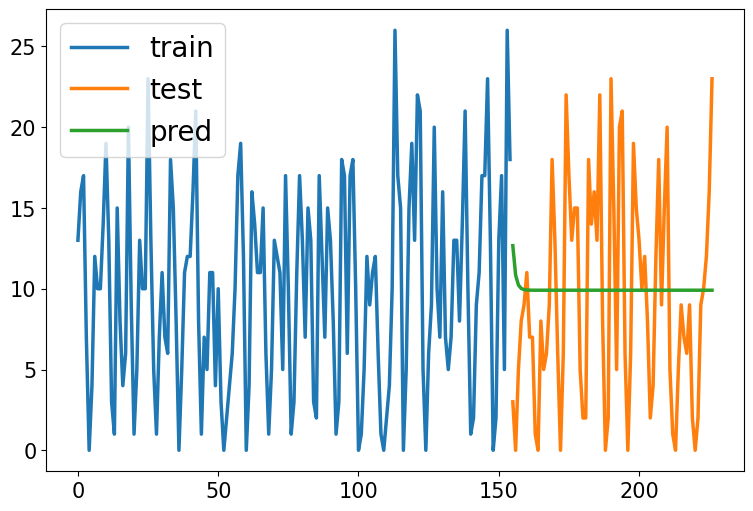

MAE 5.695
RMSE 6.686
MAD 5.092
R2 -0.028
MAPE 0.570
MAXAPE 1.321
TAPE 41.058


In [110]:
arima = ARIMA(train, order=(1,0,0)).fit()
pred = arima.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts1).items():
    print('%s %.3f' % (k, v))

With ARIMA the results are not exhaustive, we are unable to capture the variations and the trend

### SARIMAX



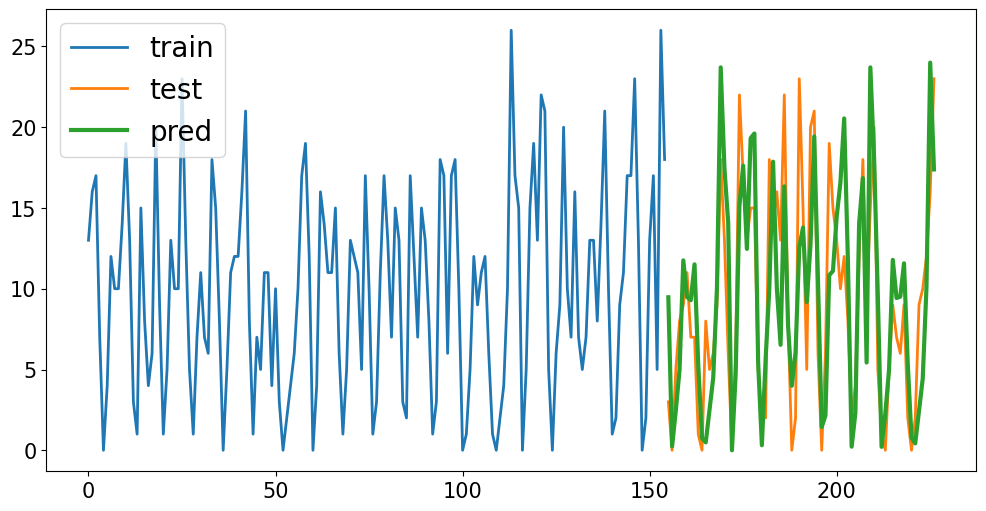

MAE 3.631
RMSE 4.420
MAD 3.435
R2 0.551
MAPE 0.989
MAXAPE 15.364
TAPE 71.177


In [132]:
sarimax = SARIMAX(train, order=(1,0,0), seasonal_order=(1, 1, 1, 56)).fit(disp=False)
pred = sarimax.predict(start=test.index[0], end=test.index[-1])
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(range(len(train)), train, label='train', linewidth=2)
plt.plot(range(len(train), len(train)+len(test)), test, label='test', linewidth=2)
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred', linewidth=3)
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts1).items():
    print('%s %.3f' % (k, v))

The best results are obtained with SARIMAX. In addition, we are somehow able to track and reproduce the trend and have good Error values

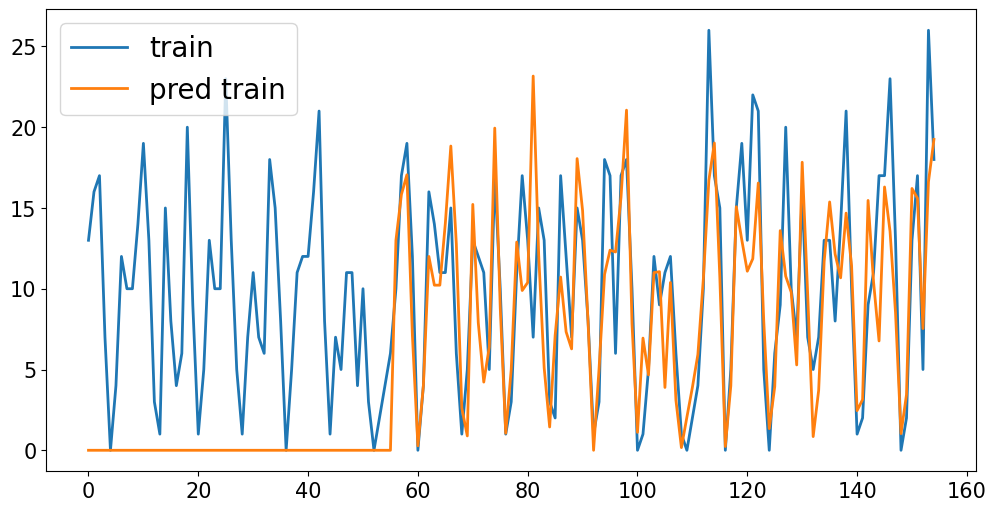

MAE 5.348
RMSE 7.287
MAD 4.000
R2 -0.345
MAPE inf
MAXAPE inf
TAPE inf


In [133]:
pred_train = sarimax.predict(start=train.index[0], end=train.index[-1])
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(range(len(train)), train, label='train', linewidth=2)
plt.plot(range(len(train)), pred_train, label='pred train', linewidth=2)
plt.legend()
plt.show()

for k, v in evaluate(train, pred_train, ts1).items():
    print('%s %.3f' % (k, v))

### Time Series Clustering

In [113]:
from tslearn.clustering import TimeSeriesKMeans

<Axes: xlabel='datetime'>

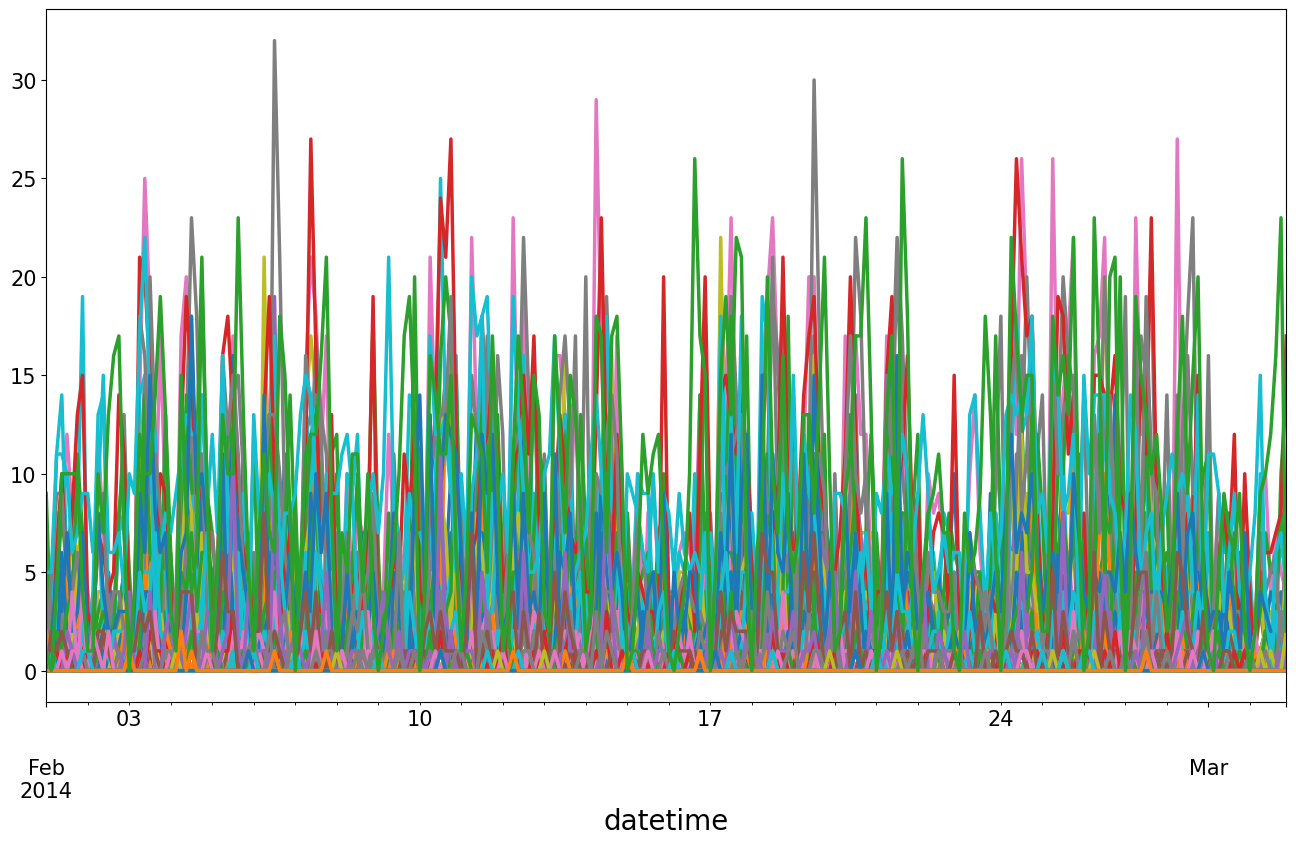

In [114]:
#All the time series for each neighborhood considered in Rome
df_all.plot(legend=False, figsize=(16, 9))

It could be interesting to group the series together, and therefore create clusters of positions that behave more or less in the same way

In [152]:
# Assuming a number of clusters equal to 3
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(np.array(df_all.T.values))

TimeSeriesKMeans(max_iter=5, random_state=0)

In [153]:
#And the number of observations are the instants of time for which we have the points
len(df_all.T.values[0])

240

Now I can plot the centroids for each cluster

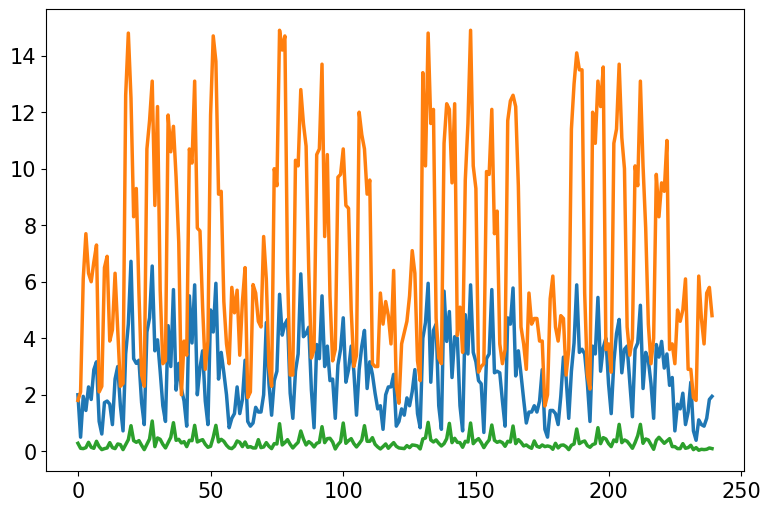

In [154]:
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.show()

In [155]:
# Labels
km.labels_

array([2, 2, 2, 0, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2,
       2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1], dtype=int64)

We can check which neighborhoods the individual labels correspond to

In [156]:
list(km.labels_).index(1)

6

In [157]:
df_all.columns[6]

'tile_6'

In [158]:
tessellation[tessellation['tile_ID'] == 6]

Name                                           geometry  \
6 0  Q.III Pinciano   POLYGON ((12.49847 41.91951, 12.49807 41.91979...   

     tile_ID  
6 0        6

In [159]:
list(km.labels_).index(2)

0

In [160]:
df_all.columns[0]

'tile_0'

In [161]:
tessellation[tessellation['tile_ID'] == 0]

Name  \
0 0  Q.VII Prenestino Labicano   

                                              geometry  tile_ID  
0 0  POLYGON ((12.55904 41.89480, 12.55903 41.89482...        0

In [162]:
list(km.labels_).index(0)

3

In [163]:
df_all.columns[3]

'tile_3'

In [164]:
tessellation[tessellation['tile_ID'] == 3]

Name                                           geometry  \
3 0  Q.VIII Tuscolano   POLYGON ((12.55313 41.87675, 12.55298 41.87680...   

     tile_ID  
3 0        3